<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/LSTM_TIMESERIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-9432a3757c9b>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 225.9162, test RMSE 425.1285
Epoch 100: train RMSE 172.4025, test RMSE 368.9035
Epoch 200: train RMSE 132.8452, test RMSE 325.0982
Epoch 300: train RMSE 102.5206, test RMSE 287.5701
Epoch 400: train RMSE 79.7783, test RMSE 254.5763
Epoch 500: train RMSE 61.3963, test RMSE 224.0832
Epoch 600: train RMSE 48.4685, test RMSE 197.5111
Epoch 700: train RMSE 39.3657, test RMSE 174.2203
Epoch 800: train RMSE 33.1485, test RMSE 154.1273
Epoch 900: train RMSE 28.9678, test RMSE 136.7351
Epoch 1000: train RMSE 25.9814, test RMSE 122.8639
Epoch 1100: train RMSE 24.5029, test RMSE 111.7684
Epoch 1200: train RMSE 23.0078, test RMSE 102.7273
Epoch 1300: train RMSE 21.9490, test RMSE 95.8267
Epoch 1400: train RMSE 21.3708, test RMSE 89.4266
Epoch 1500: train RMSE 20.9572, test RMSE 85.4829
Epoch 1600: train RMSE 20.2346, test RMSE 81.5276
Epoch 1700: train RMSE 19.9712, test RMSE 79.2584
Epoch 1800: train RMSE 21.0414, test RMSE 78.2036
Epoch 1900: train RMSE 19.1984, test RMSE 74.

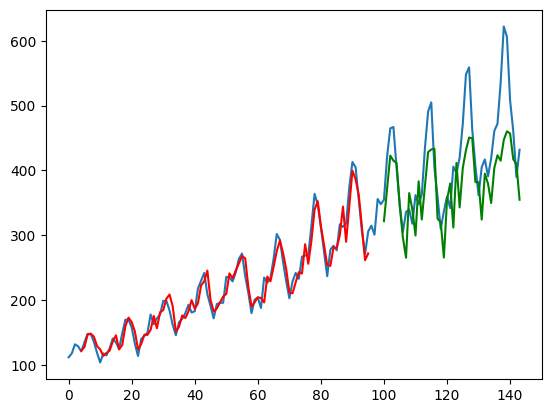

In [2]:
#https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


# https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
# MODIFIED BY FRANK MORALES NOVEMBER 11TH
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
#df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()
